# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: CodeChallenge: Data normalization
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [124]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [125]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(f'labels shape: {labels.shape}, data shape: {data.shape}')

labels shape: (20000,), data shape: (20000, 784)


# Create train/test groups using DataLoader

In [126]:
# Step 1: convert to tensor
dataT = torch.tensor(data).float().to(device)
labelsT = torch.tensor(labels).long().to(device)

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# REMINDER:
# 0) normalize train to [0 1] and test to [0 1]
# 1) normalize train to [0 1] and test to [0 255]
# 2) normalize train to [0 255] and test to [0 1]
train_data = train_data / torch.max(train_data)
# test_data = test_data / torch.max(test_data)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])


In [127]:
# Confirm ranges of train and test data
print('Training data range %g to %g'
      % (torch.min(train_loader.dataset.tensors[0]).item(), torch.max(train_loader.dataset.tensors[0]).item()))

print('Test data range %g to %g'
      % (torch.min(test_loader.dataset.tensors[0]).item(), torch.max(test_loader.dataset.tensors[0]).item()))

Training data range 0 to 1
Test data range 0 to 255


# Create the DL model

In [128]:
# create a class for the model
def createTheMNISTNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 64)

            ### hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ### output layer
            self.output = nn.Linear(32, 10)


        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfun, optimizer

# Create a function that trains the model

In [129]:
def compute_accuracy(y, yHat):
    matches = torch.argmax(yHat, axis=1) == y  # booleans (false/true)
    matchesNumeric = matches.float()  # convert to numbers (0/1)
    accuracyPct = 100 * torch.mean(matchesNumeric)  # average and x100
    return accuracyPct

In [130]:
# a function that trains the model

def function2trainTheModel():
    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()
    
    # move the model to the GPU
    net.to(device)

    # initialize losses
    losses = torch.zeros((numepochs, 2))
    trainAcc = []
    testAcc = []

    print("\n\nStarting training. Epochs: ", end='')
    
    # loop over epochs
    for epochi in range(numepochs):
        # print the epochi number:
        print(epochi, end=' ')
        
        # loop over TRAINING data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader: # X, y are the minibatches (not an individual sample)
            # Move the minibatches to GPU
            X, y = X.to(device), y.to(device)
            
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute TRAINING accuracy for this batch
            accuracyPct = compute_accuracy(y, yHat)
            batchAcc.append(accuracyPct)  # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        # Average TRAINING accuracy across all batches for this epoch
        trainAcc.append(np.mean([acc.cpu() for acc in batchAcc]))

        # and get average TRAINING losses across the batches
        losses[epochi, 0] = np.mean(batchLoss)


        # -------------- TEST DATA COMPUTATIONS -------------- #
        # TEST accuracy
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        X, y = X.to(device), y.to(device)  # move to GPU
        with torch.no_grad():  # deactivates autograd
            yHat = net(X)  # forward pass the TEST data through the model trained on TRAINING data

        # compute accuracy for the TEST data
        accuracyPct = compute_accuracy(y, yHat)
        testAcc.append(accuracyPct.cpu())
        
        # compute TEST loss
        loss = lossfun(yHat, y)
        losses[epochi, 1] = loss.item()

    # end epochs

    # function output
    return trainAcc, testAcc, losses, net


# Run the model and show the results!

In [131]:
trainAcc, testAcc, losses, net = function2trainTheModel()




Starting training. Epochs: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

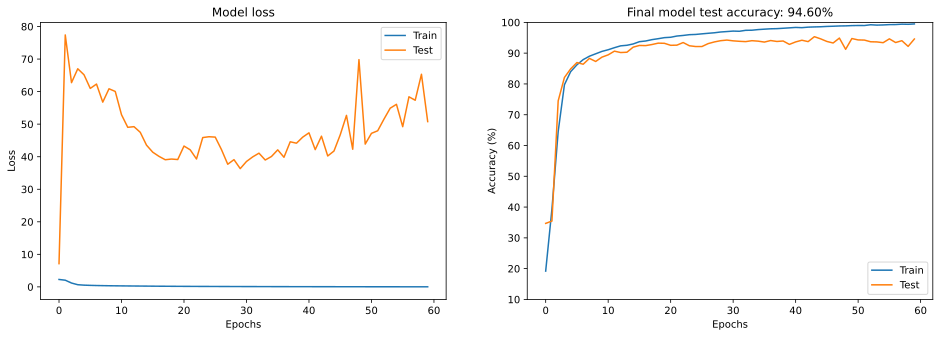

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.cpu())  # losses includes both train and test losses (losses[:,0] and losses[:,1])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Optional explorations

In [133]:
# 1) Try different normalizations, e.g., [-1 0] or [10 15]. How do these affect learning?
# 
# 2) Correlate loss and accuracy over epochs, and visualize in a scatterplot. Do the loss and 
#    accuracy functions really provide different information, or do the two variables reflect
#    the same underlying performance? (Note that your conclusion here is based exclusively on this 
#    dataset and this architecture!)